In [1]:
import psycopg2
from io import StringIO
import pandas as pd
import os
import traceback
from sqlalchemy import create_engine, MetaData
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold, RepeatedKFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, roc_auc_score
from imblearn.over_sampling import RandomOverSampler
from lightgbm import LGBMClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_file = "/disco-grande/datos.csv"
# limit = 10000
df = pd.read_csv(data_file)

In [4]:
df.head()

,dep_name,esi,age,gender,ethnicity,race,lang,religion,maritalstatus,employstatus,insurance_status,disposition,arrivalmode,arrivalmonth,arrivalday,arrivalhour_bin,previousdispo,2ndarymalig,abdomhernia,abdomnlpain,abortcompl,acqfootdef,acrenlfail,acutecvd,acutemi,acutphanm,adjustmentdisorders,adltrespfl,alcoholrelateddisorders,allergy,amniosdx,analrectal,anemia,aneurysm,anxietydisorders,appendicitis,artembolism,asppneumon,asthma,attentiondeficitconductdisruptivebeha,backproblem,biliarydx,birthasphyx,birthtrauma,bladdercncr,blindness,bnignutneo,bonectcncr,bph,brainnscan,breastcancr,breastdx,brnchlngca,bronchitis,burns,cardiaarrst,cardiacanom,carditis,cataract,cervixcancr,chestpain,chfnonhp,chrkidneydisease,coaghemrdx,coloncancer,comabrndmg,complicdevi,complicproc,conduction,contraceptiv,copd,coronathero,crushinjury,cysticfibro,deliriumdementiaamnesticothercognitiv,developmentaldisorders,diabmelnoc,diabmelwcm,disordersusuallydiagnosedininfancych,diverticulos,dizziness,dminpreg,dysrhythmia,earlylabor,ecodesadverseeffectsofmedicalcare,ecodesadverseeffectsofmedicaldrugs,ecodescutpierce,ecodesdrowningsubmersion,ecodesfall,ecodesfirearm,ecodesfireburn,ecodesmachinery,ecodesmotorvehicletrafficmvt,ecodesnaturalenvironment,ecodesotherspecifiedandclassifiable,ecodesotherspecifiednec,ecodespedalcyclistnotmvt,ecodesplaceofoccurrence,ecodespoisoning,ecodesstruckbyagainst,ecodessuffocation,ecodestransportnotmvt,ecodesunspecified,ectopicpreg,encephalitis,endometrios,epilepsycnv,esophcancer,esophgealdx,exameval,eyeinfectn,fatigue,femgenitca,feminfertil,fetaldistrs,fluidelcdx,fuo,fxarm,fxhip,fxleg,fxskullfac,gangrene,gasduoulcer,gastritis,gastroent,giconganom,gihemorrhag,giperitcan,glaucoma,goutotcrys,guconganom,hdnckcancr,headachemig,hemmorhoids,hemorrpreg,hepatitis,hivinfectn,hodgkinsds,hrtvalvedx,htn,htncomplicn,htninpreg,hyperlipidem,immunitydx,immunizscrn,impulsecontroldisordersnec,inducabortn,infectarth,influenza,infmalegen,intestinfct,intobstruct,intracrninj,jointinjury,kidnyrnlca,lateeffcvd,leukemias,liveborn,liveribdca,longpregncy,lowbirthwt,lungexternl,lymphenlarg,maintchemr,malgenitca,maligneopls,malposition,meningitis,menopausldx,menstrualdx,miscellaneousmentalhealthdisorders,mooddisorders,mouthdx,ms,multmyeloma,mycoses,nauseavomit,neoplsmunsp,nephritis,nervcongan,nonepithca,nonhodglym,nutritdefic,obrelatedperintrauma,opnwndextr,opnwndhead,osteoarthros,osteoporosis,otacqdefor,otaftercare,otbnignneo,otbonedx,otcirculdx,otcomplbir,otconganom,otconntiss,otdxbladdr,otdxkidney,otdxstomch,otendodsor,otfemalgen,othbactinf,othcnsinfx,othematldx,othercvd,othereardx,otheredcns,othereyedx,othergidx,othergudx,otherinjury,otherpregnancyanddeliveryincludingnormal,otherscreen,othfracture,othheartdx,othinfectns,othliverdx,othlowresp,othmalegen,othnervdx,othskindx,othveindx,otinflskin,otitismedia,otjointdx,otnutritdx,otperintdx,otpregcomp,otprimryca,otrespirca,otupprresp,otuprspin,ovariancyst,ovarycancer,pancreascan,pancreasdx,paralysis,parkinsons,pathologfx,pelvicobstr,perintjaund,peripathero,peritonitis,personalitydisorders,phlebitis,pid,pleurisy,pneumonia,poisnnonmed,poisnotmed,poisonpsych,precereoccl,prevcsectn,prolapse,prostatecan,pulmhartdx,rctmanusca,rehab,respdistres,retinaldx,rheumarth,schizophreniaandotherpsychoticdisorde,screeningandhistoryofmentalhealthan,septicemia,septicemiaexceptinlabor,sexualinfxs,shock,sicklecell,skininfectn,skinmelanom,sle,socialadmin,spincorinj,spontabortn,sprain,stomchcancr,substancerelateddisorders,suicideandintentionalselfinflictedin,superficinj,syncope,teethdx,testiscancr,thyroidcncr,thyroiddsor,tia,tonsillitis,tuberculosis,ulceratcol,ulcerskin,umbilcord,unclassified,urinstone,urinyorgca,uteruscancr,uti,varicosevn,viralinfect,whtblooddx,n_edvisits,n_admissions,absolutelymphocytecount_last,acetonebld_last,alanineaminotransferase(alt)_last,albumin_last,alkphos_last,anc(absneutrophilcount)_last,aniongap_last,aspartateaminotransferase(ast)_last,"b-typenatriureticpeptide,pro(probnp)_last",baseexcess(poc)_last,"baseex

In [234]:
# df["meds_cardiovascular"].unique()
df = df[df["cc_chestpain"] !=-2147483648]

In [6]:
ingresados = df["disposition"] == "Admit"
no_ingresados = df["disposition"] == "Discharge"

In [7]:
# Categorical boolean mask
categorical_feature_mask = df.dtypes==object
# filter categorical columns using mask and turn it into a list
categorical_cols = df.columns[categorical_feature_mask].tolist()
categorical_cols_enc = [f"{col}_enc" for col in categorical_cols]

In [8]:
null_columns= []
for col in df.columns:
    num_nulos = df[col].isna().sum()
    if num_nulos:
        null_columns.append((col, num_nulos))
total_count = len(df)
NULL_THREESHOLD = 0.4
# exclude_columns = [col for col, count in null_columns if  count / total_count > NULL_THREESHOLD  ]
exclude_columns = [col for col, count in null_columns]

In [226]:
for col, l in null_columns:
    df[col] = df[col].fillna(0)

In [15]:
for cat_col in categorical_cols:
    le = LabelEncoder()
    df[f"{cat_col}_enc"] = le.fit_transform(df[cat_col])

In [9]:
df["disposition"] =  df["disposition"].apply(lambda x: 1 if x  == 'Admit' else 0)

In [10]:
df["disposition_str"] = df["disposition"].apply(lambda x: 'Ingresado' if x  == 1 else 'No ingresado')

In [11]:
def plot_column(cat_col, title=None, xlabel=None, ylabel=None, idx=None, figsize=(17,5)):
    plt.figure(figsize=figsize)
    title = title or cat_col
    plt.title(f"{title}")
#     sns.countplot(df[ingresados][cat_col])
#     plt.figure(figsize=(17,5))
#     plt.title(f"{title} no ingresados")
#     sns.countplot(df[no_ingresados][cat_col]) 
    if idx is not None and idx.any():
        ax = sns.countplot(x=cat_col, hue="disposition_str", data=df[idx])
    else:
        ax = sns.countplot(x=cat_col, hue="disposition_str", data=df)
    if xlabel and ylabel:
        ax.set(xlabel=xlabel, ylabel=ylabel)

In [13]:
def print_cors(cols):
#     df_tmp = pd.DataFrame(columns=['col', 'value'])
    cs = []
    corrs = []
    cols = [col for col in cols if col not in exclude_columns]
    for col in cols:
        c = df["disposition"].corr(df[col])
#         df_tmp = df_tmp.append([col, c ])
        cs.append(col)
        corrs.append(c)
    return  pd.DataFrame({'corr': corrs, 'col':cs  }).sort_values("corr",ascending=False)


In [19]:
print_cors([col for col in categorical_cols_enc if col != 'disposition_enc'])

,corr,col
9,0.170809,arrivalmode_enc
3,0.130537,race_enc
7,0.129594,employstatus_enc
2,0.078731,ethnicity_enc
8,0.034519,insurance_status_enc
1,0.019766,gender_enc
11,0.000426,arrivalday_enc
10,-0.000305,arrivalmonth_enc
12,-0.014913,arrivalhour_bin_enc
4,-0.025271,lang_enc


In [18]:
df_corr = print_cors([col for col in df.columns[df.dtypes!=object].tolist() if col not in  ['disposition','disposition_enc'] ])
# df_corr.sort_values()


,corr,col
345,0.438030,meds_cardiovascular
354,0.389867,meds_gastrointestinal
368,0.341414,meds_vitamins
322,0.337318,meds_analgesics
339,0.330536,meds_antiplateletdrugs
362,0.321239,meds_psychotherapeuticdrugs
351,0.316287,meds_diuretics
344,0.307748,meds_cardiacdrugs
353,0.306428,meds_elect/caloric/h2o
327,0.271216,meds_antiasthmatics


In [32]:
df_corr_sorted = df_corr.iloc[(-df_corr["corr"]).abs().argsort()][::-1]

In [40]:
df_corr_sorted[~df_corr_sorted["corr"].isna()][:30]["col"].tolist()

['meds_cardiovascular',
 'esi',
 'meds_gastrointestinal',
 'meds_vitamins',
 'meds_analgesics',
 'meds_antiplateletdrugs',
 'meds_psychotherapeuticdrugs',
 'meds_diuretics',
 'meds_cardiacdrugs',
 'meds_elect/caloric/h2o',
 'meds_antiasthmatics',
 'meds_antihyperglycemics',
 'htn',
 'meds_cnsdrugs',
 'meds_unclassifieddrugproducts',
 'meds_anticoagulants',
 'meds_thyroidpreps',
 'meds_eentpreps',
 'meds_hormones',
 'meds_antiarthritics',
 'n_surgeries',
 'coronathero',
 'hyperlipidem',
 'chfnonhp',
 'n_admissions',
 'meds_antibiotics',
 'arrivalmode_enc',
 'diabmelnoc',
 'chrkidneydisease',
 'dysrhythmia']

In [20]:
df.esi.corr(df.disposition)

-0.43519691156666346

In [100]:
df["meds_cardiovascular"]

array([0., 2., 1., 3., 4., 5., 6., 7., 8., 9.])

In [ ]:
df["meds_cardiovascular"].

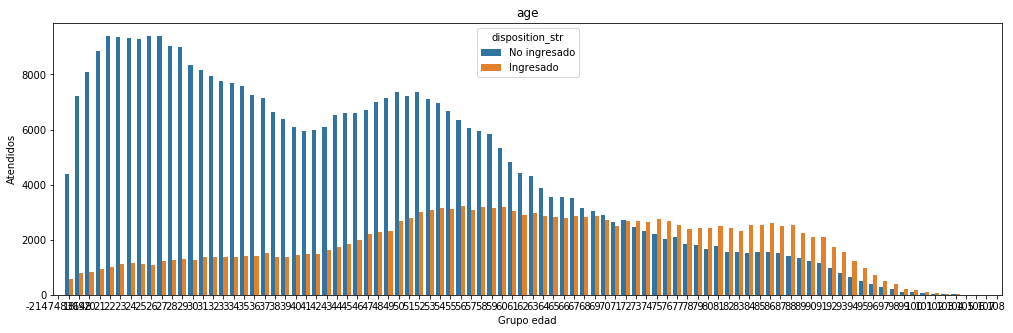

In [130]:
plot_column("age")

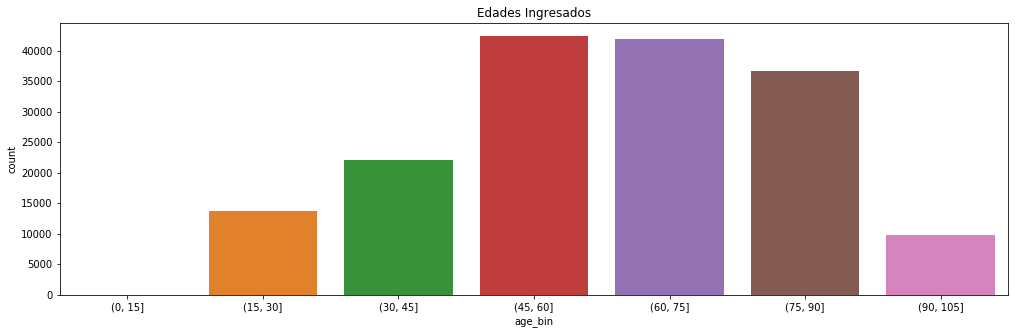

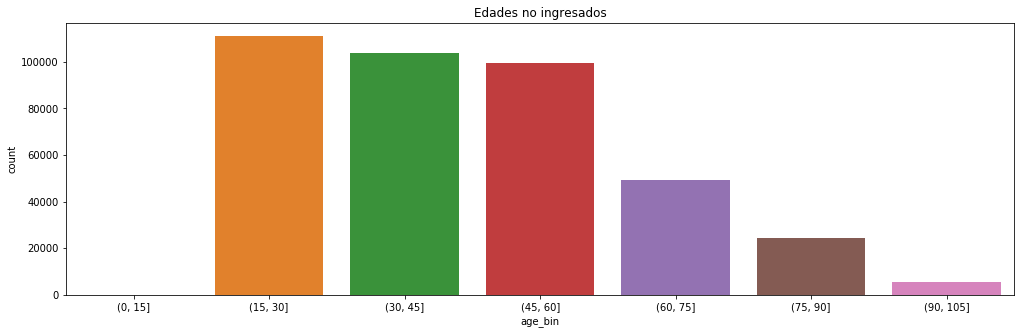

In [98]:
df["age_bin"] = pd.cut(df["age"], bins=np.arange(0, 120, 15))
plot_column("age_bin", "Edades")

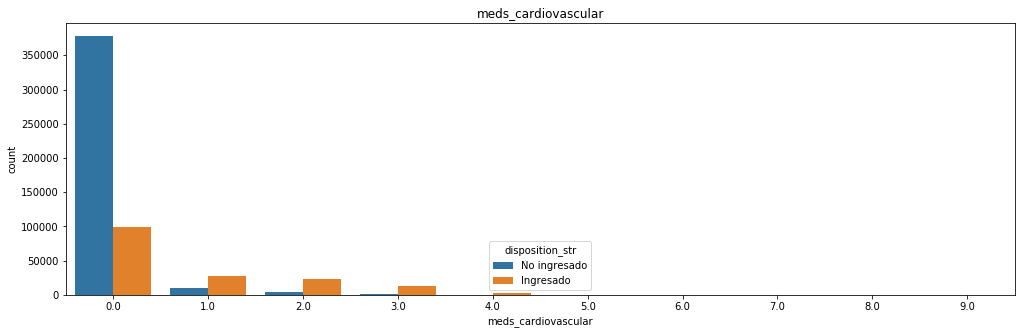

In [134]:
plot_column("meds_cardiovascular")

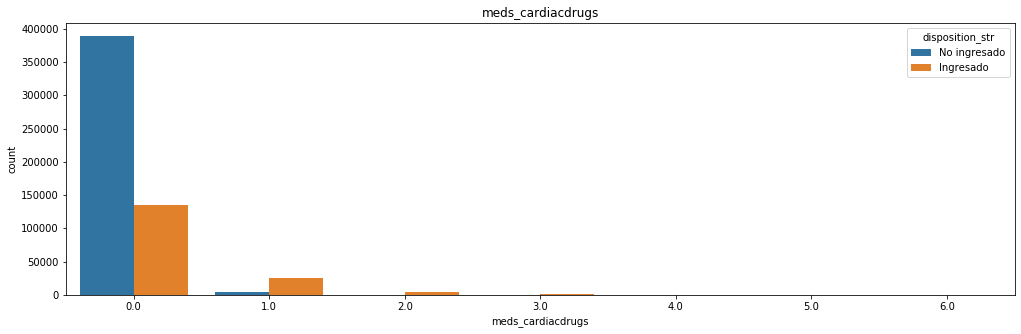

In [135]:
plot_column("meds_cardiacdrugs")

/disco-grande/projects/proyecto-hospital/venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


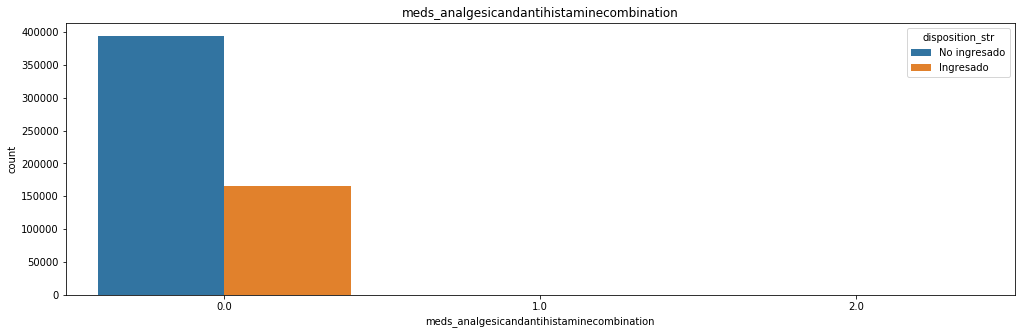

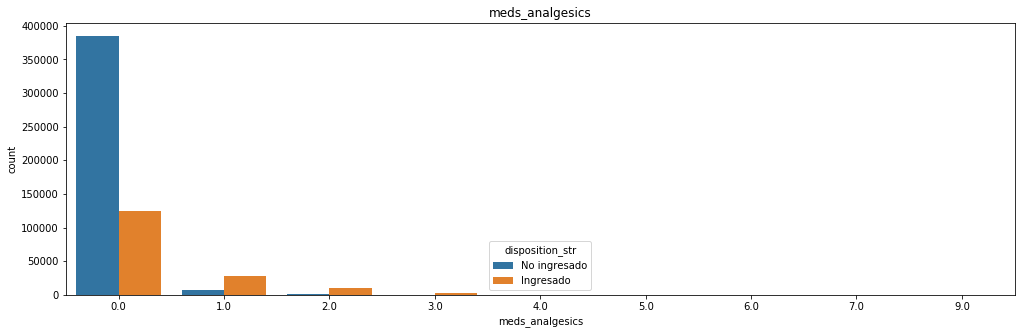

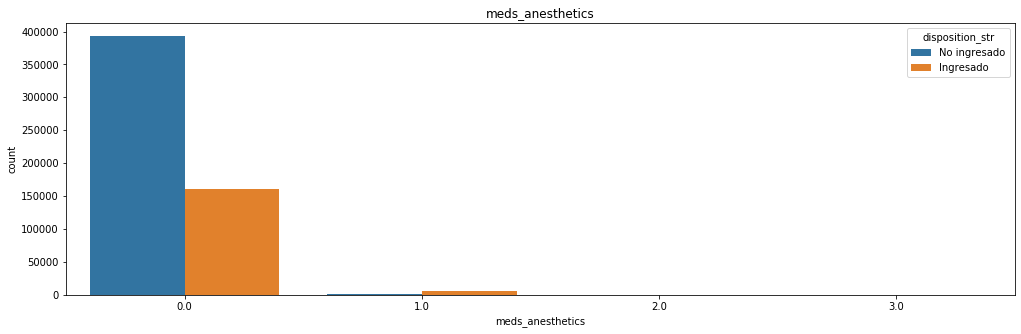

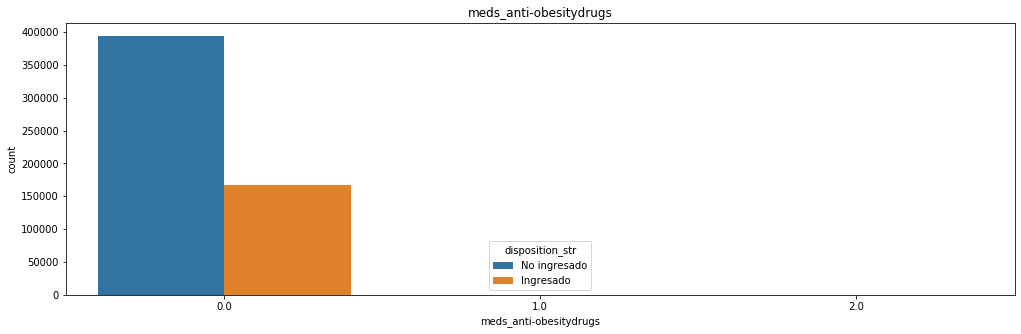

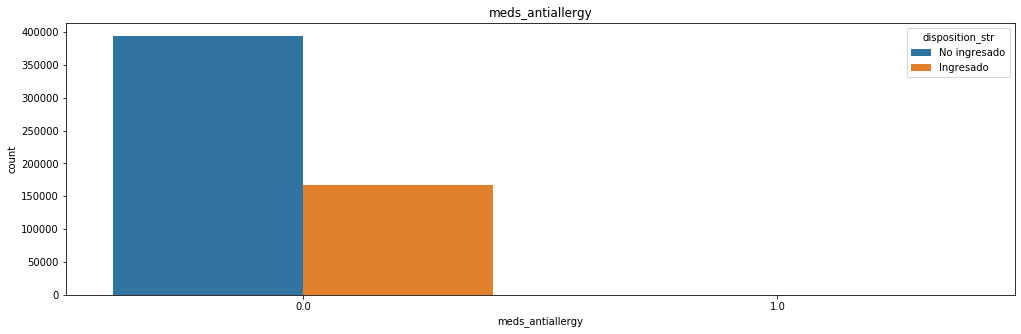

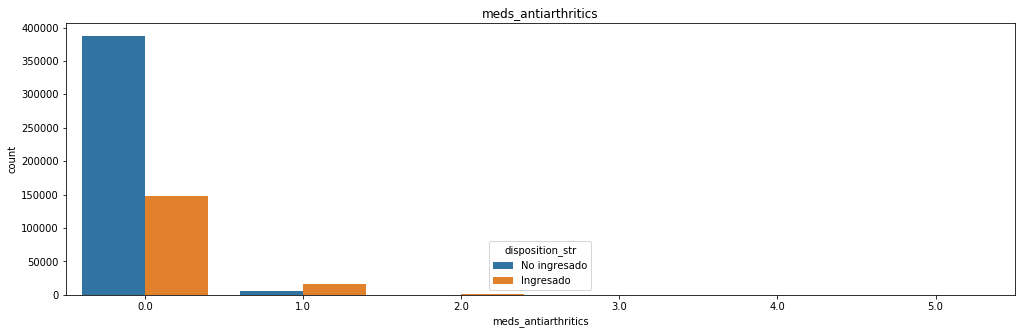

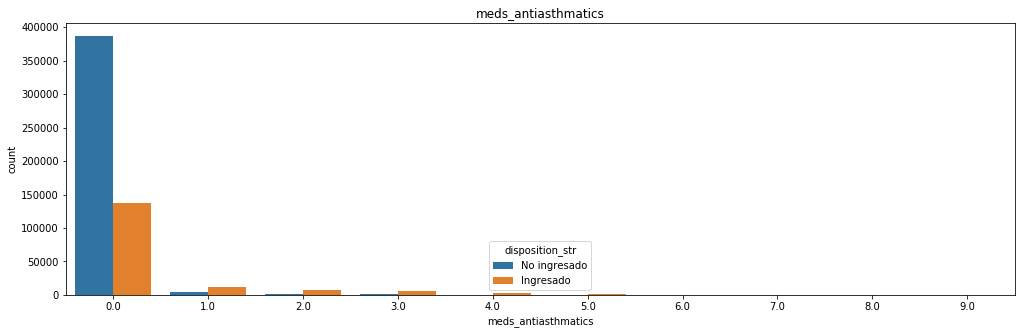

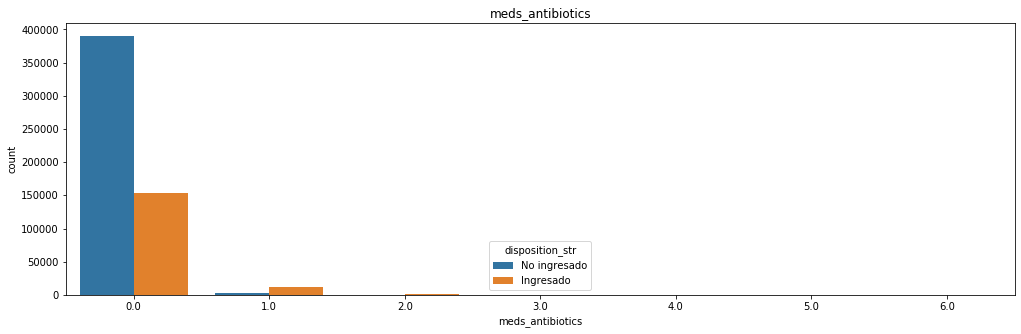

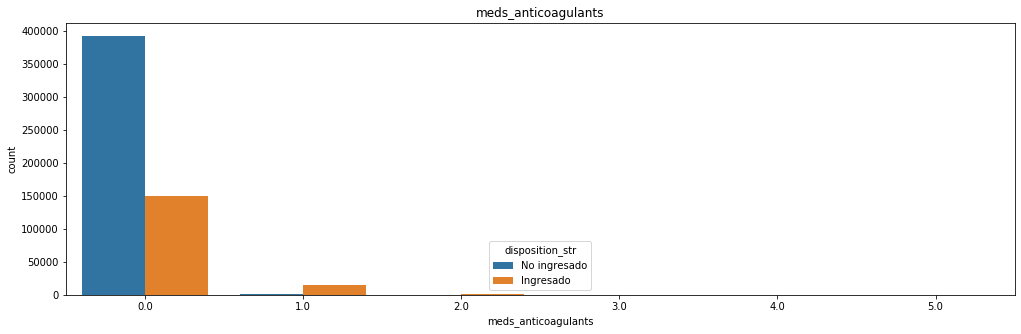

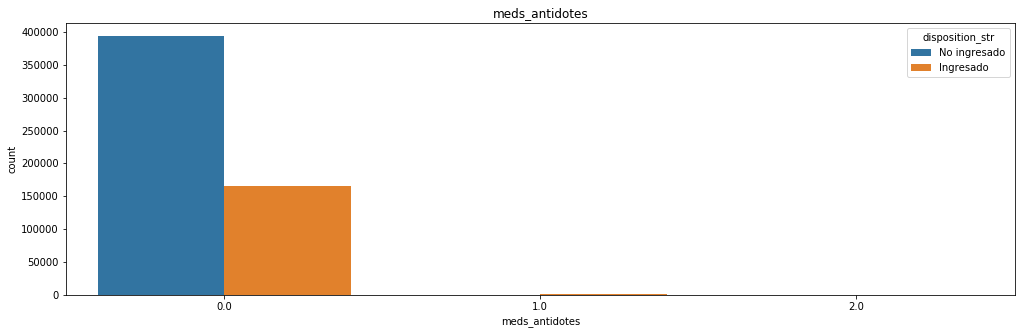

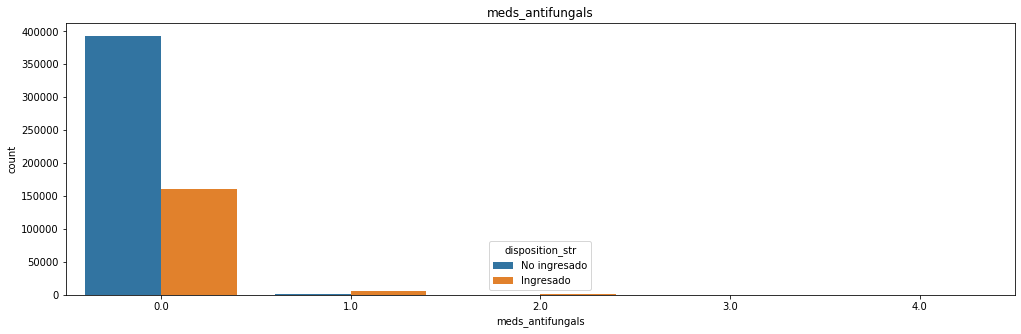

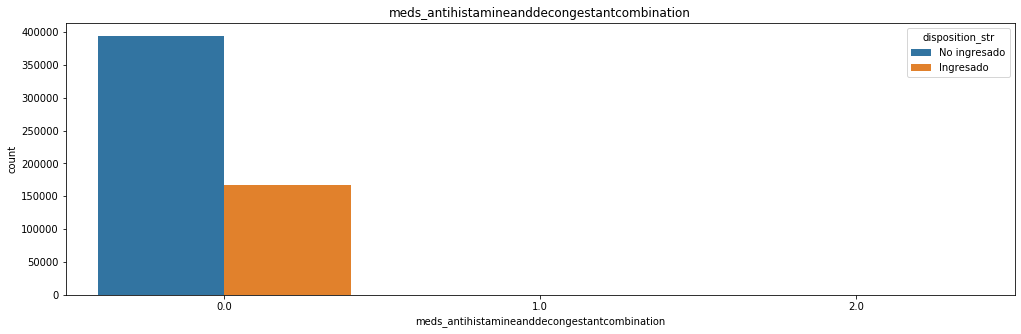

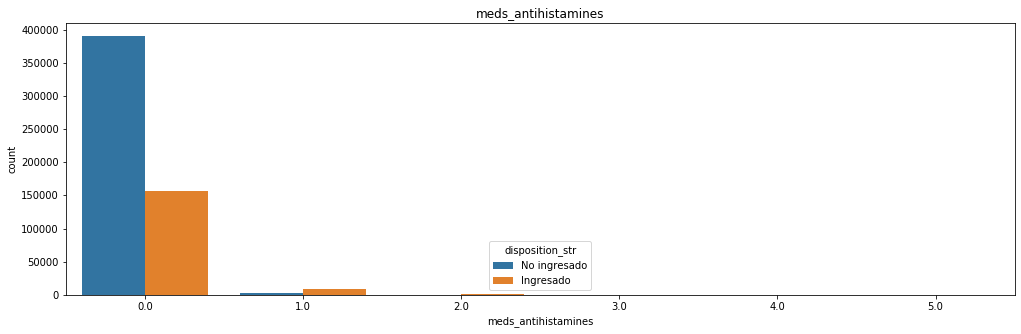

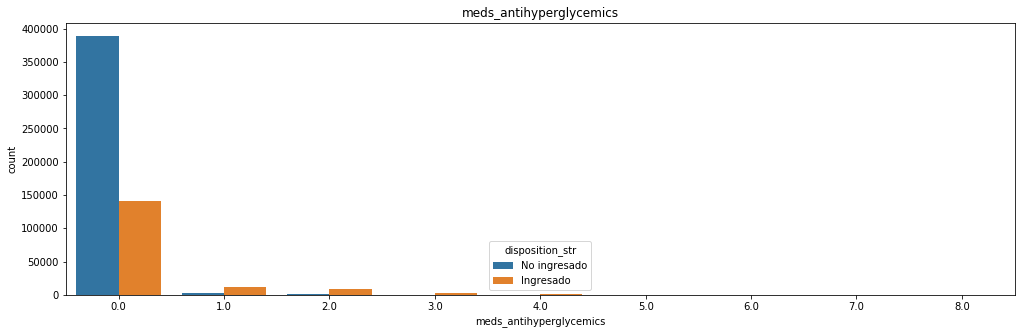

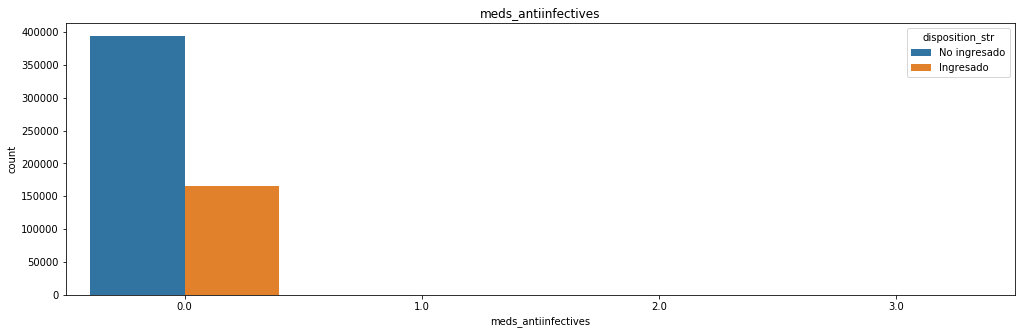

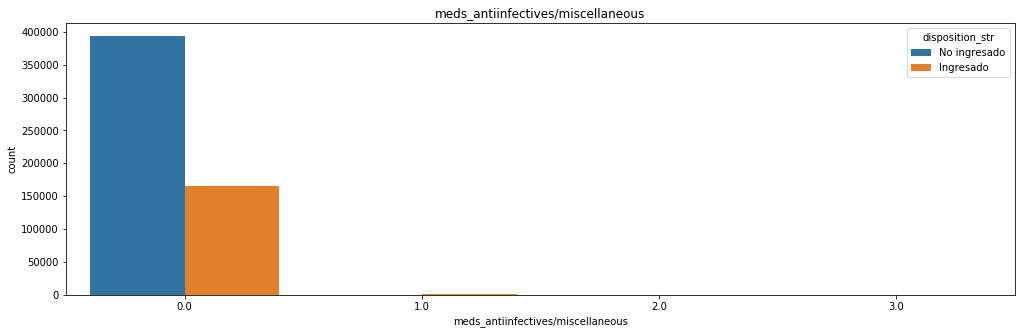

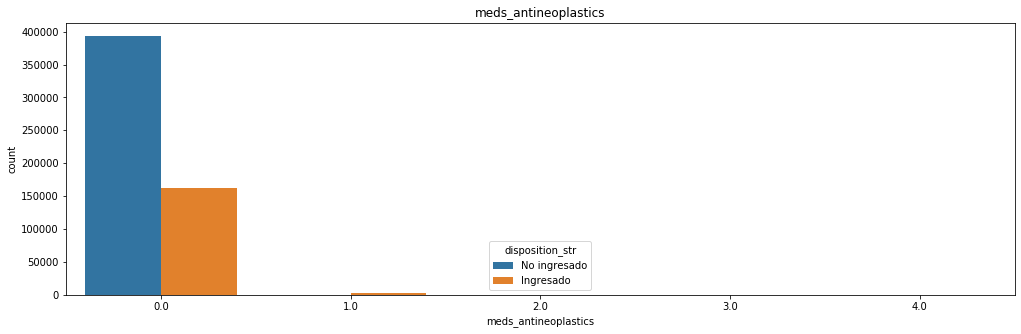

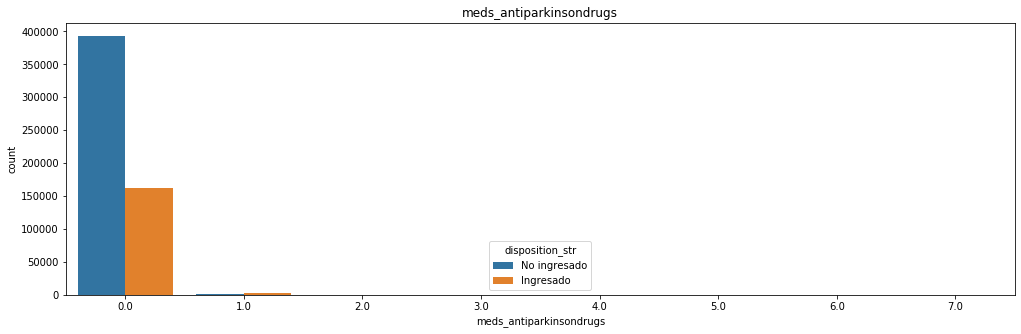

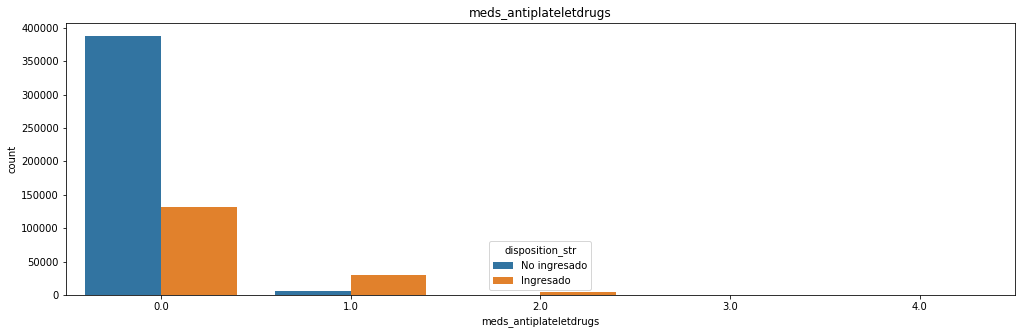

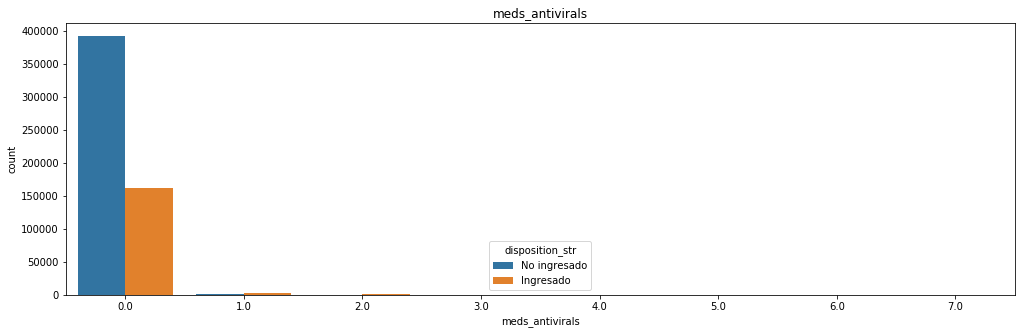

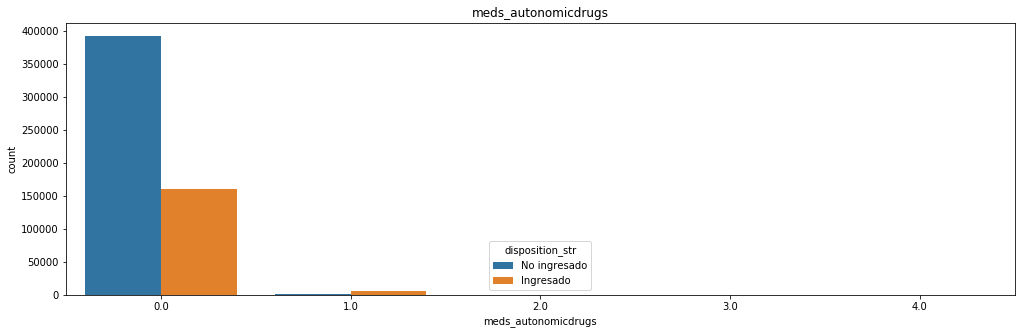

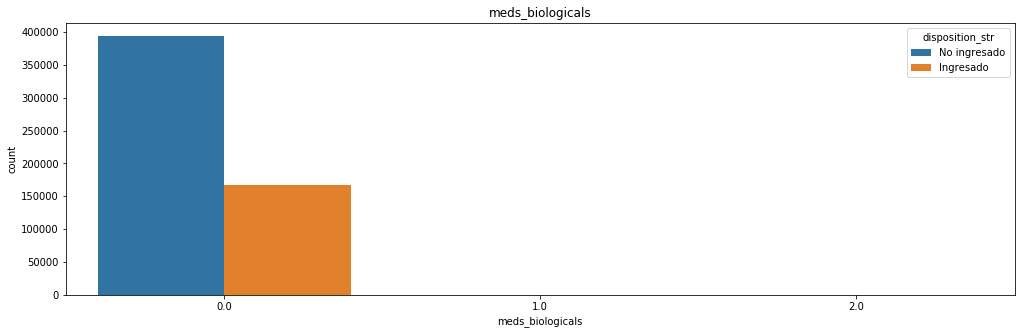

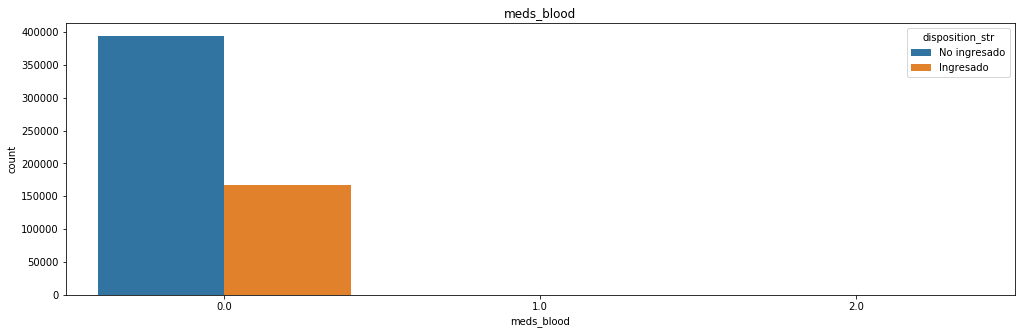

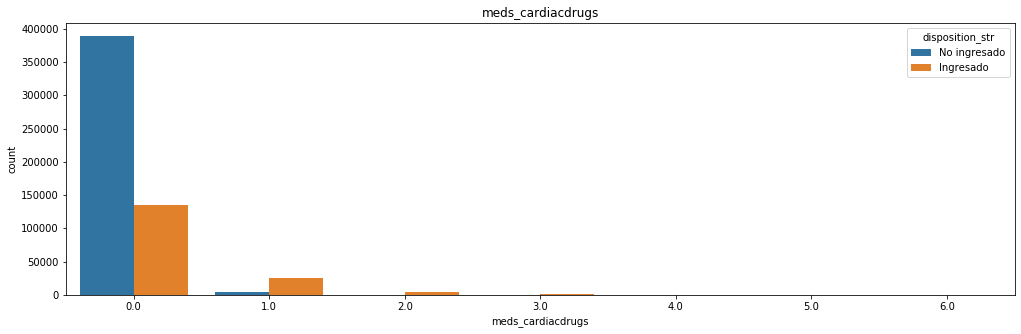

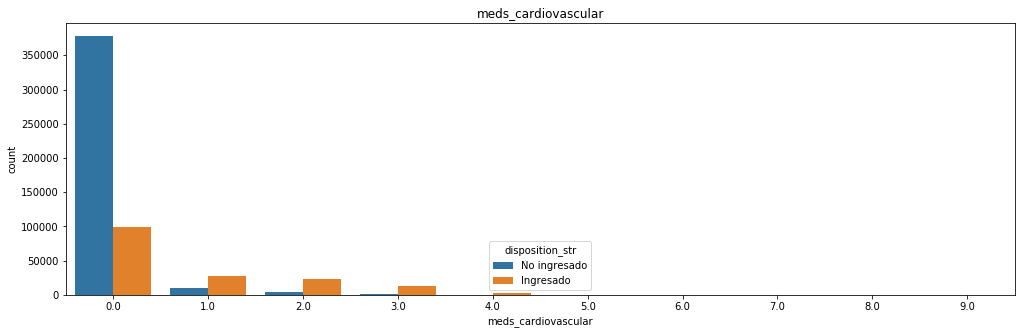

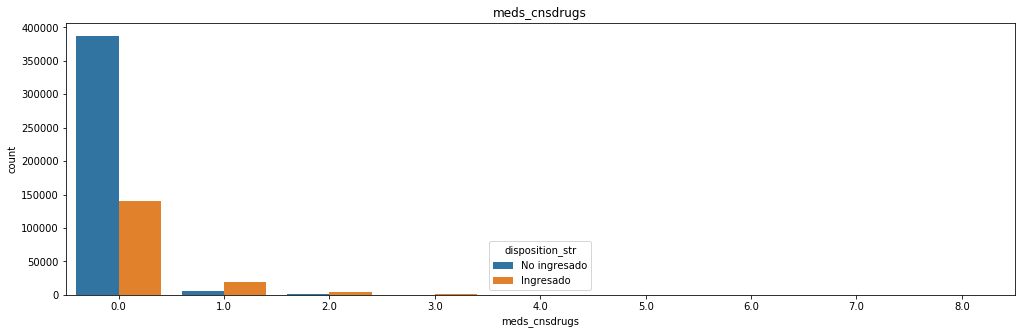

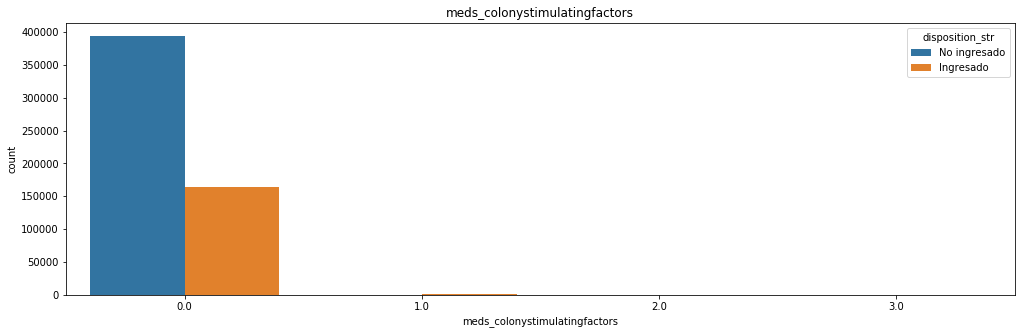

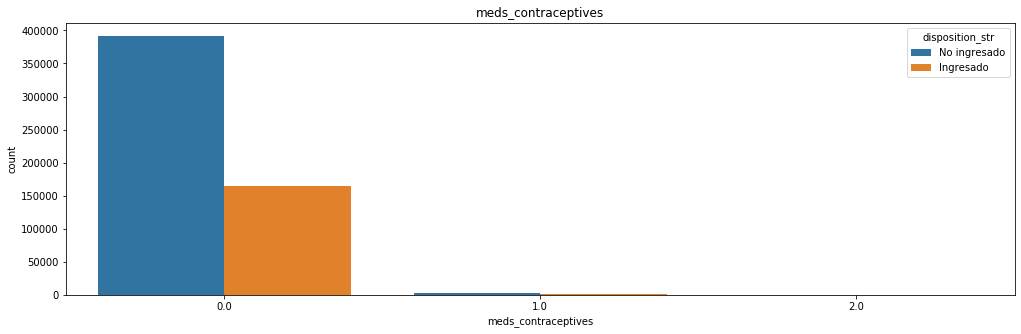

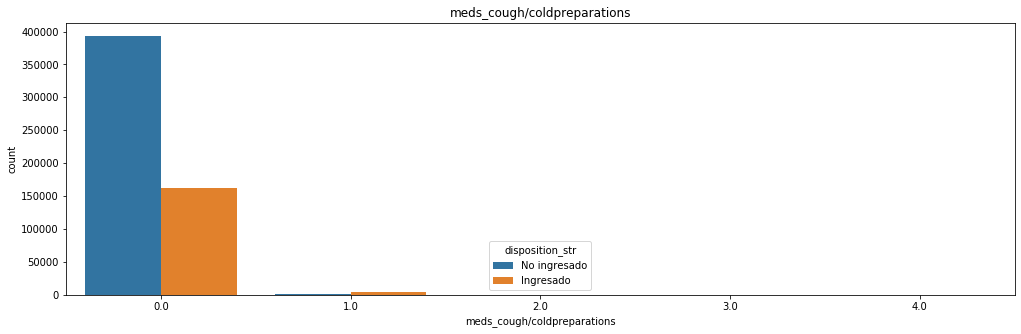

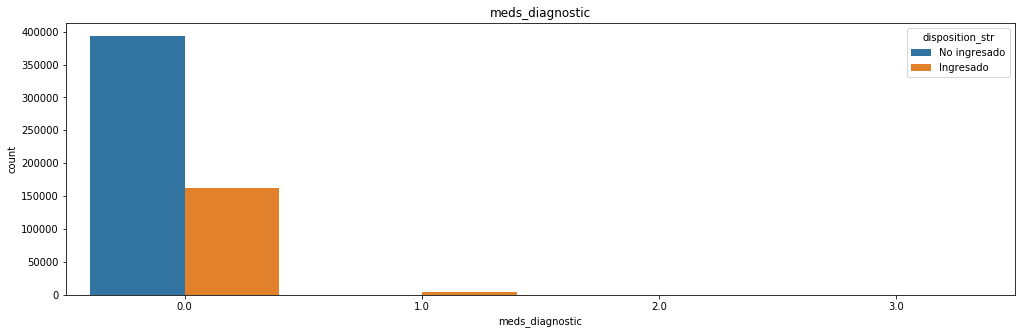

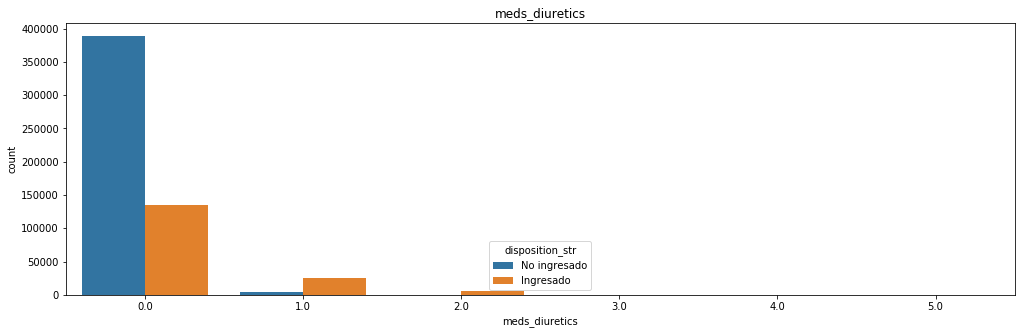

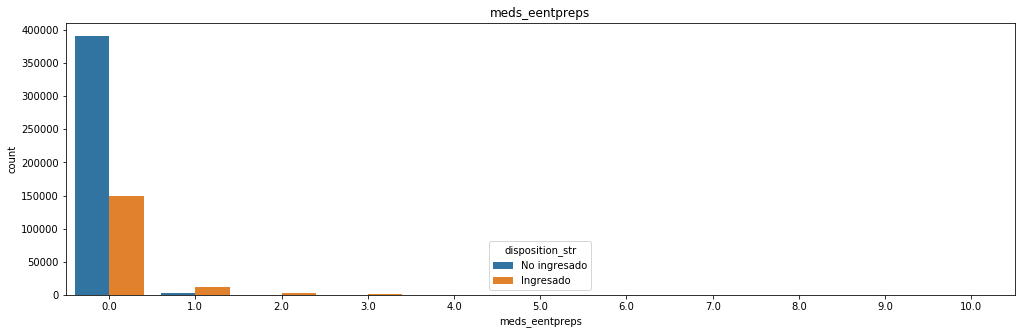

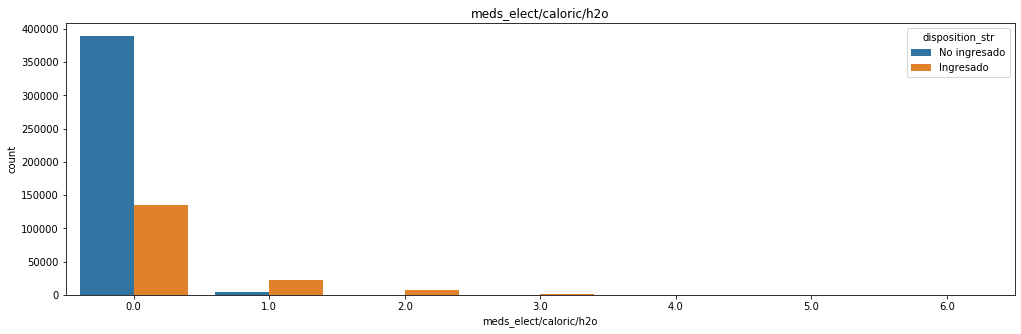

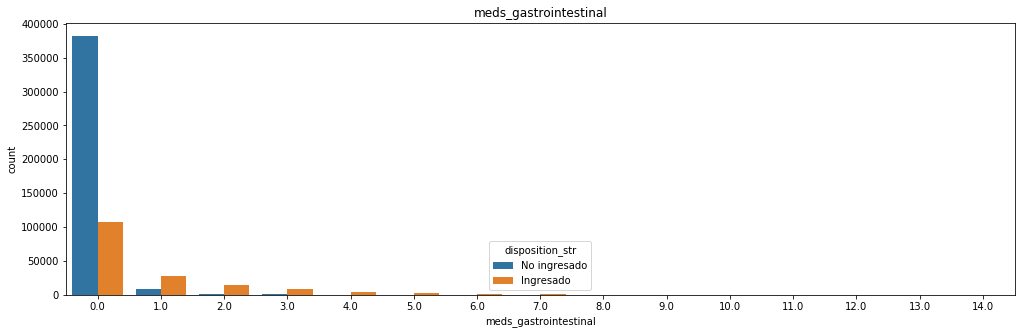

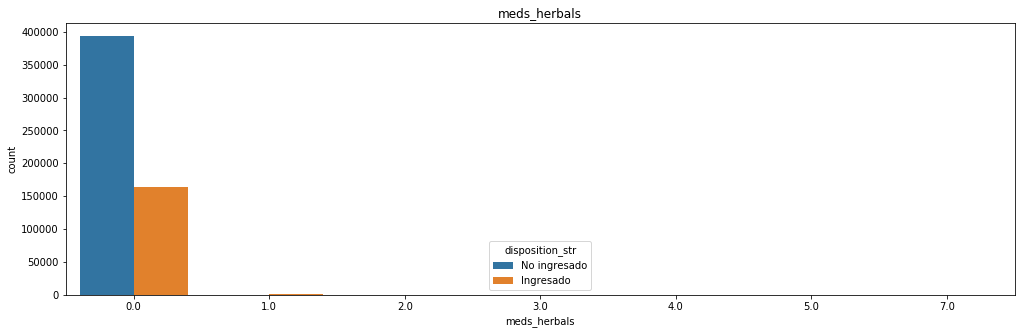

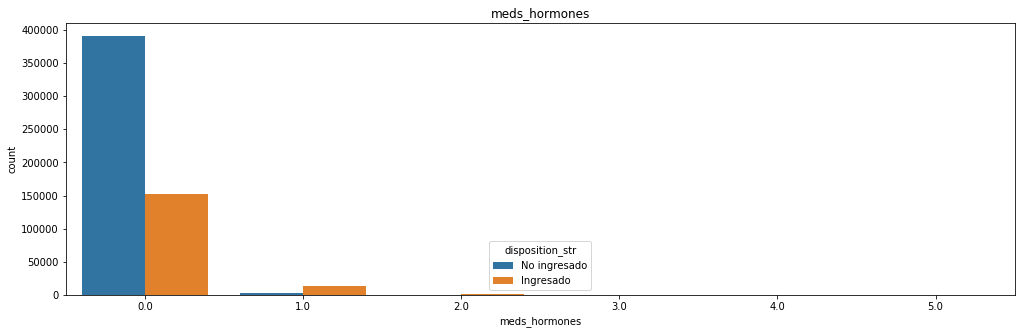

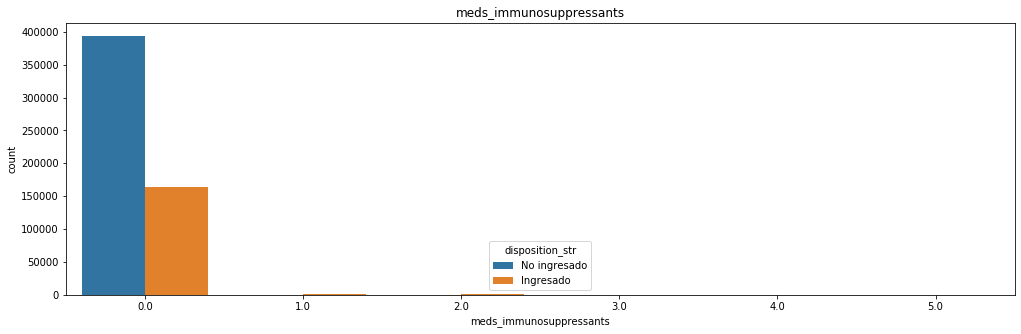

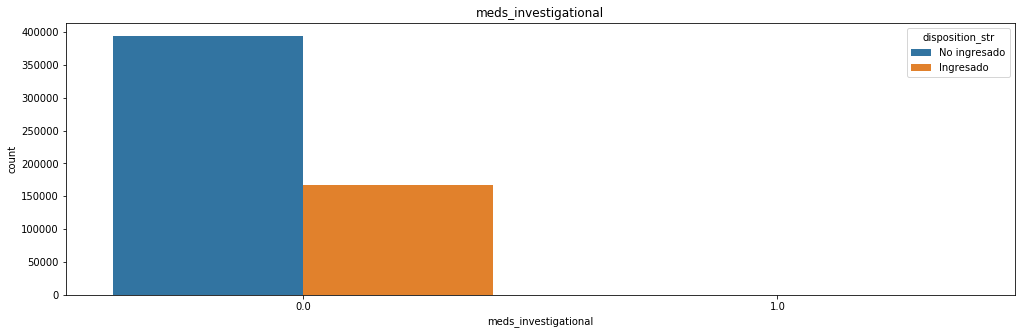

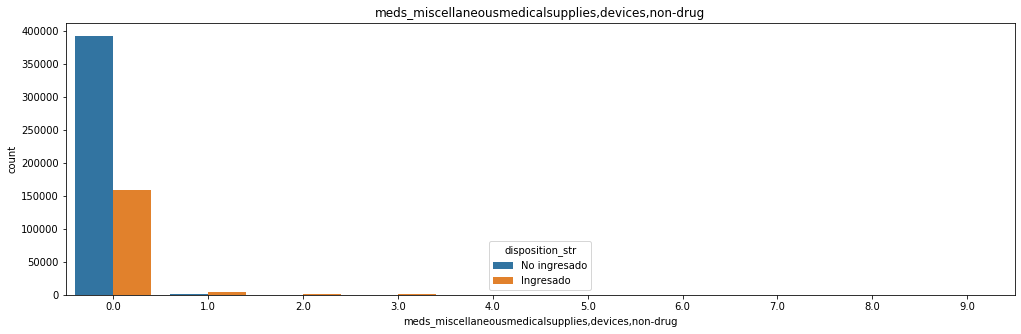

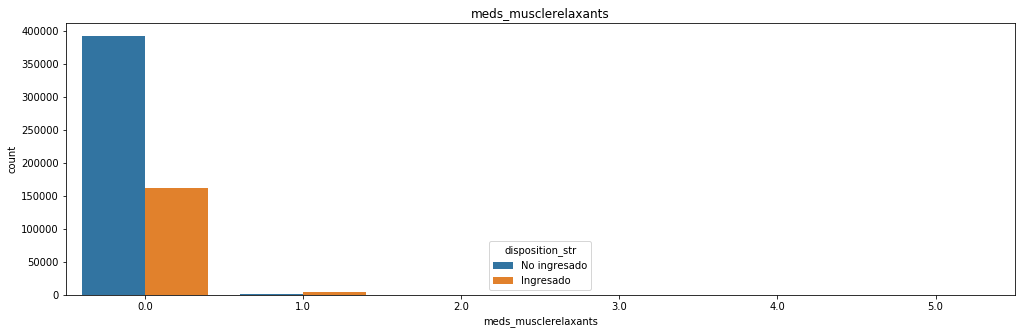

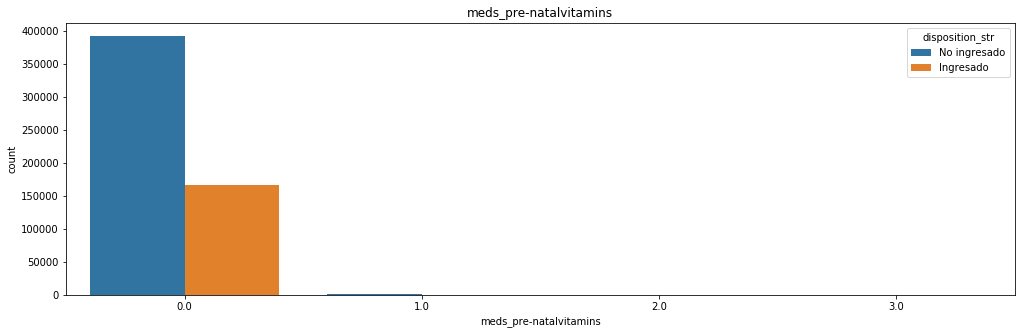

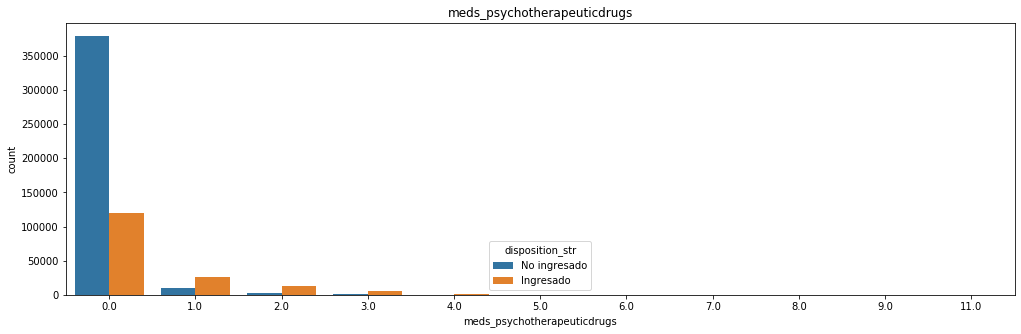

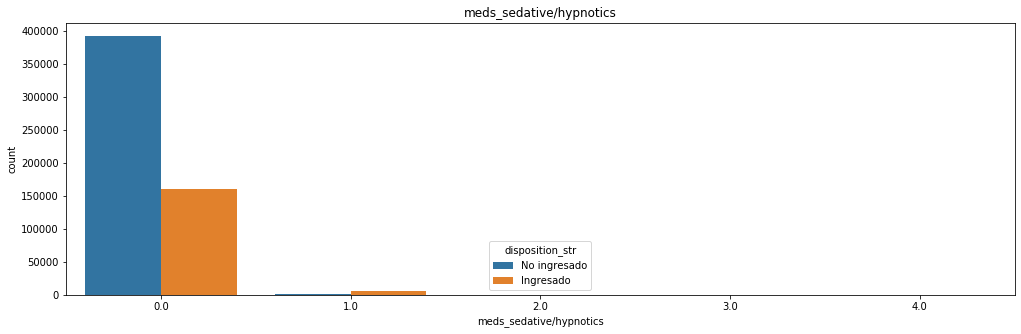

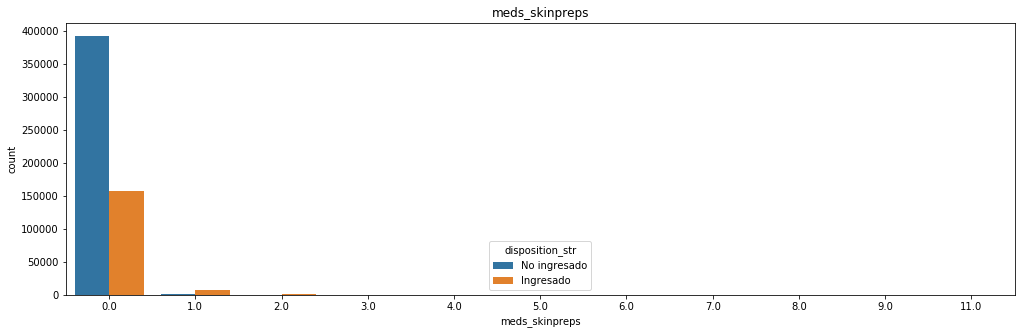

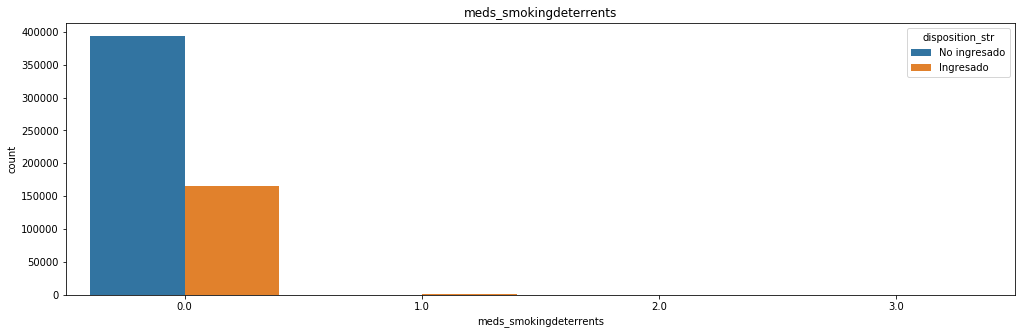

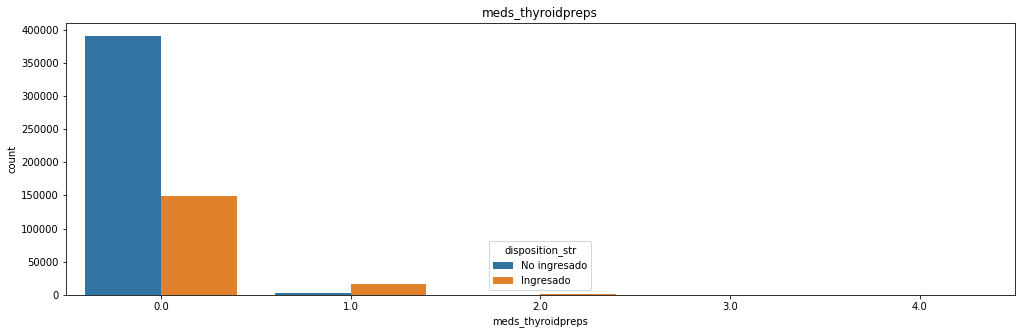

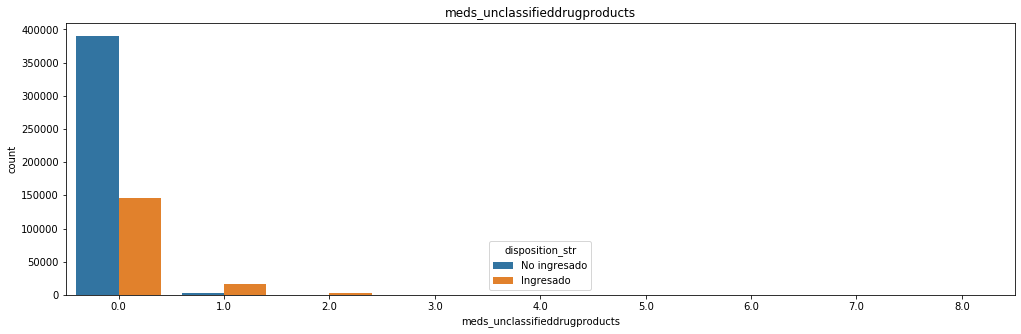

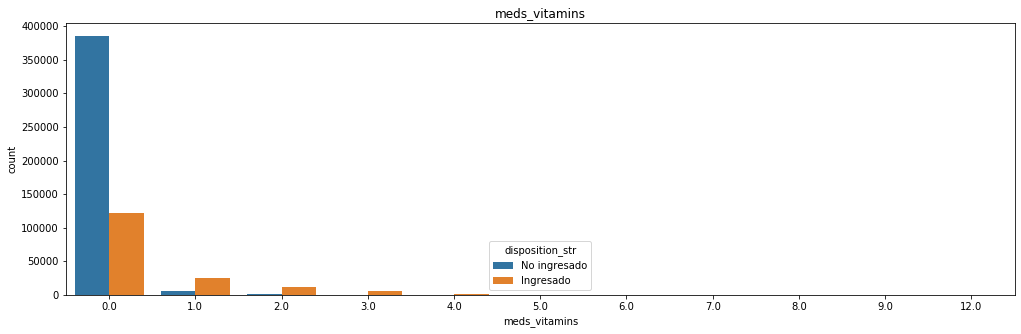

In [136]:
for col in meds_columns:
    plot_column(col)

In [67]:
df["epithelialcells_last"].isna().sum()

560478

In [54]:
print_cors([col for col in df.columns if col.startswith("cc_")])

,corr,col
163,-0.012789,cc_shortnessofbreath
31,-0.012789,cc_chestpain
11,-0.012789,cc_alteredmentalstatus
192,-0.012789,cc_weakness
72,-0.012789,cc_fall>65
2,-0.012789,cc_abdominalpain
90,-0.012789,cc_gibleeding
4,-0.012789,cc_abnormallab
77,-0.012789,cc_fever-9weeksto74years
176,-0.012789,cc_syncope


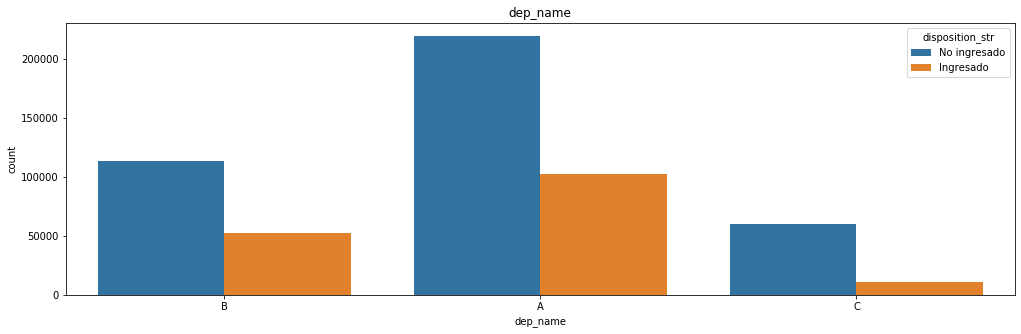

In [137]:
plot_column("dep_name")

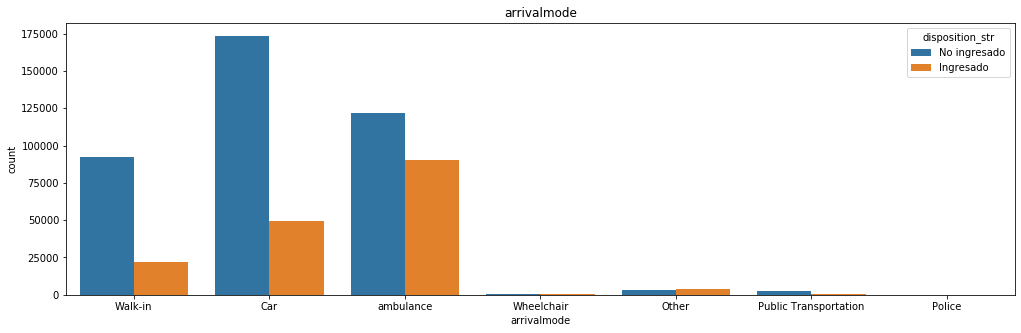

In [138]:
plot_column("arrivalmode")

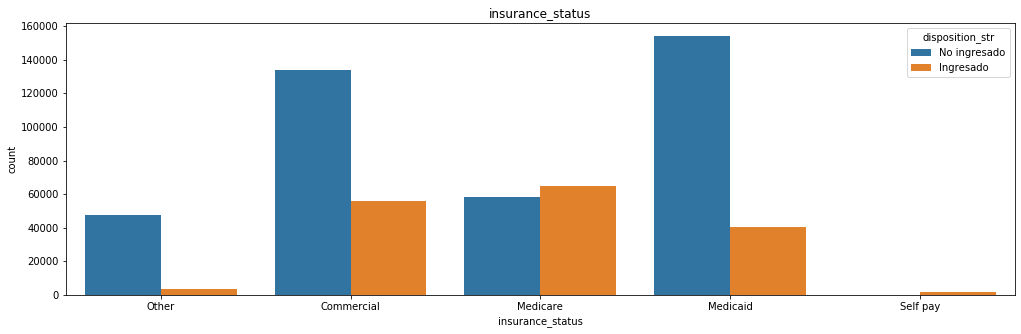

In [139]:
plot_column("insurance_status")

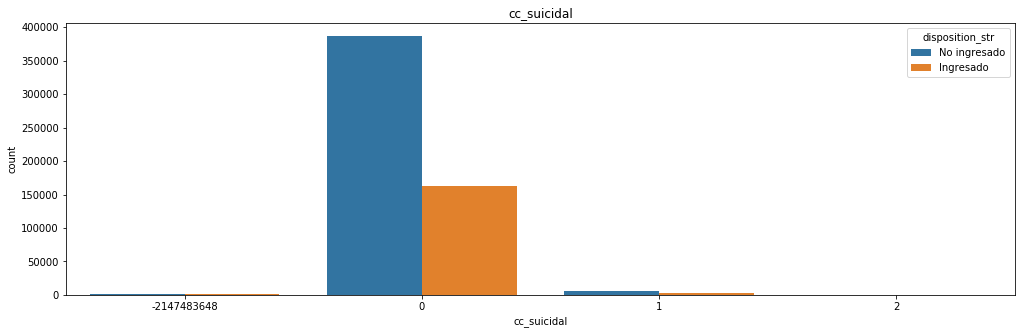

In [141]:
plot_column("cc_suicidal")

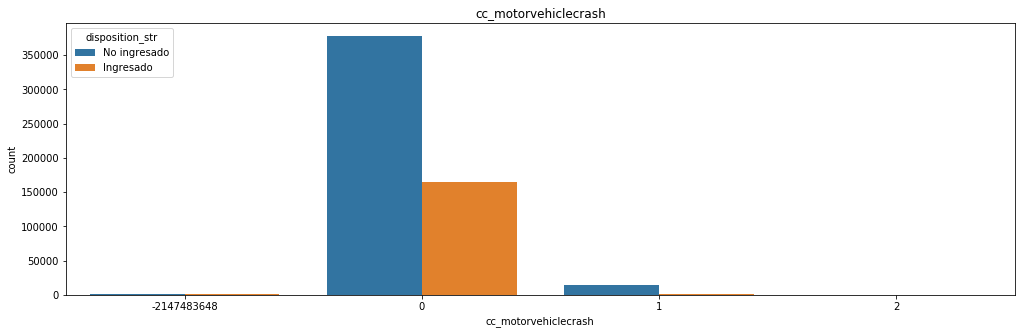

In [140]:
plot_column("cc_motorvehiclecrash")

In [ ]:
plot_column("cc_medicalproblem")

# Deteccion de outliers


In [142]:
meds_columns = [col for col in df.columns if col.startswith("meds_")]

In [143]:
len(meds_columns)

48

In [5]:
for col in meds_columns:
    iqr = df[col].quantile(0.25) - df[col].quantile(0.75)
    print(f"{col} {iqr}")

NameError: name 'meds_columns' is not defined

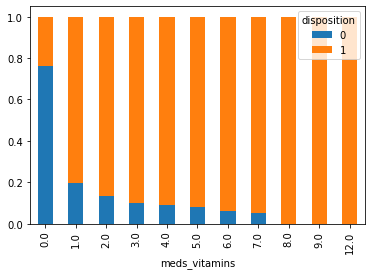

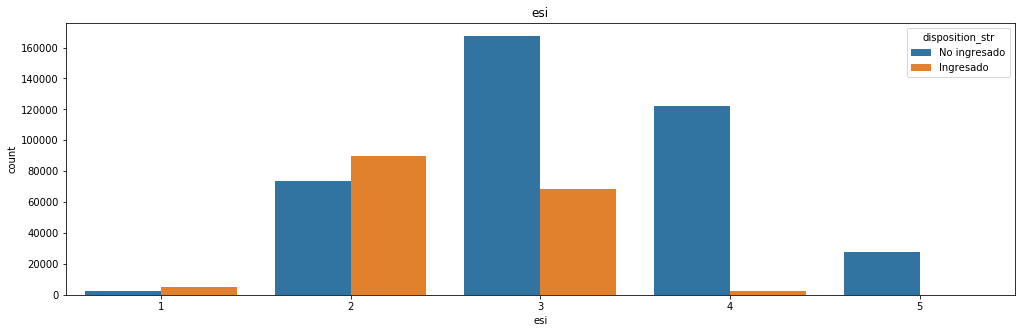

In [147]:
plot_column("esi")

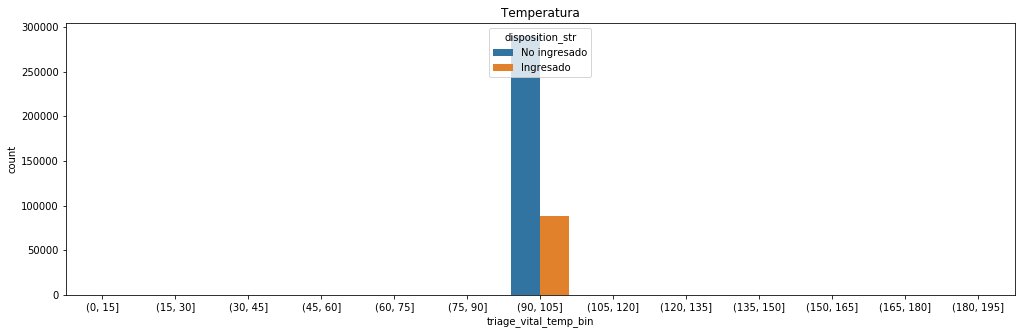

In [149]:
df["triage_vital_temp_bin"] = pd.cut(df["triage_vital_temp"], bins=np.arange(0, 200, 15))
plot_column("triage_vital_temp_bin", "Temperatura")

In [158]:
def plot_bins(col, slot=15, *args, **kwargs):
    min_val = df[col].min()
    max_val = df[col].max()
    df[f"{col}_bin"] = pd.cut(df[col], bins=np.arange(min_val, max_val, slot))
    plot_column(f"{col}_bin", *args, **kwargs)

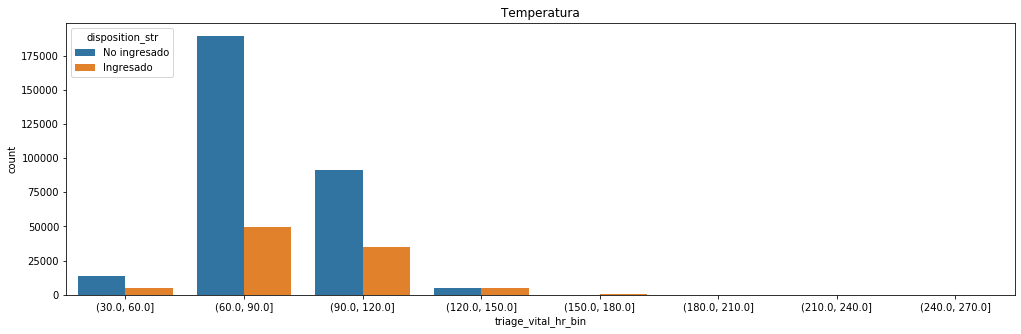

In [161]:
plot_bins("triage_vital_hr",30, "Temperatura")

In [162]:
df["n_edvisits"].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  18,  17,  19,  20,  22,  21,  23,  24,  25,
        26,  27,  29,  30,  31,  33,  34,  35,  36,  28,  32,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  55,  56,  57,  58,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  59,  54,  74,  75,  76,  77,
        78,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 108, 109, 110,  79,  96, 107, 111, 112, 113, 114, 115, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 129, 130, 131,
       133, 134, 137, 138, 139, 141, 142, 143, 144, 146, 126, 116, 132,
       135, 136, 140, 145, 147, 148, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170,
       171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 18

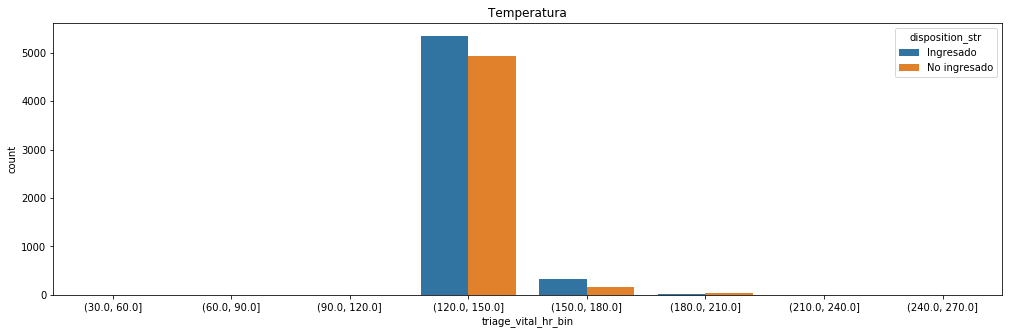

In [207]:
plot_bins("triage_vital_hr",30, "Temperatura", idx=(df["triage_vital_hr"] > 120))
# df[df["triage_vital_hr"] > 120]

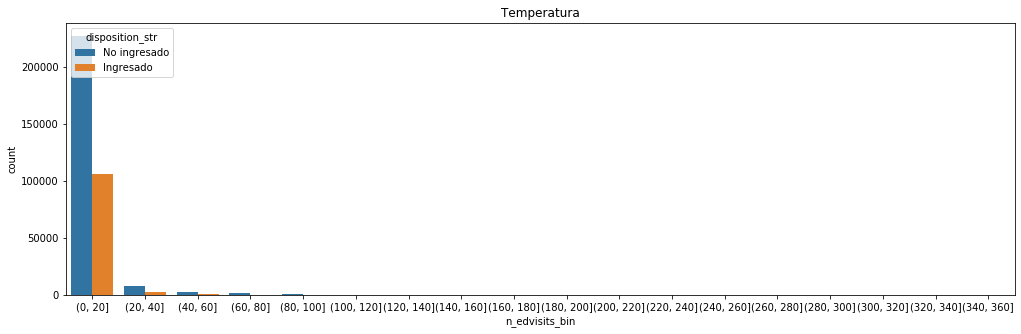

In [165]:
plot_bins("n_edvisits",20, "Temperatura")

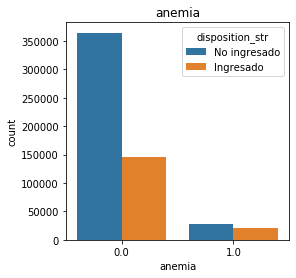

In [236]:
plot_column("anemia", figsize=(4,4))

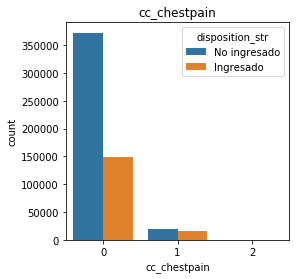

In [235]:
plot_column("cc_chestpain", figsize=(4,4))

In [239]:
df["cc_chestpain"].unique()
# df[df["cc_chestpain"] ==-2147483648]
df["cc_chestpain"].value_counts()
df[df["cc_chestpain"] == 2]

dep_name  esi  age  gender     ethnicity                       race  \
4928          B    3   38  Female  Non-Hispanic  Black or African American   
44583         B    2   68    Male  Non-Hispanic         White or Caucasian   
66239         B    3   81  Female  Non-Hispanic  Black or African American   
105338        B    2   59  Female  Non-Hispanic         White or Caucasian   
282140        B    3   29  Female  Non-Hispanic         White or Caucasian   
323665        B    3   85    Male  Non-Hispanic         White or Caucasian   
391464        B    2   71  Female  Non-Hispanic         White or Caucasian   
444049        B    3   67    Male  Non-Hispanic         White or Caucasian   
485760        A    4   19    Male  Non-Hispanic  Black or African American   
548566        A    2   59  Female  Non-Hispanic         White or Caucasian   

           lang     religion maritalstatus   employstatus insurance_status  \
4928    English    Christian        Single  Self Employed         Medicaid   
44583   English     Catholic      Divorced        Retired       Commercial   
66239   English      Baptist       Widowed        Retired         Medicare   
105338  English  Pentecostal        Single       Disabled         Medicaid   
282140  English     Catholic        Single   Not Employed         Medicaid   
323665  English     Catholic       Married        Retired       Commercial   
391464  English     Catholic       Widowed        Retired         Medicare   
444049  English     Catholic      Divorced        Retired       Commercial   
485760  English         None        Single   Not Employed       Commercial   
548566  English     Catholic       Married   Not Employed         Medicaid   

        disposition arrivalmode arrivalmonth arrivalday arrivalhour_bin  \
4928              0         Car      January   Thursday           07-10   
44583             1   ambulance     February  Wednesday           07-10   
66239             1   ambulance        April   Thursday           03-06   
105338            1   ambulance      January  Wednesday           11-14   
282140            0         Car        March  Wednesday           15-18   
323665            1   ambulance        April     Sunday           15-18   
391464            0   ambulance      October     Friday           07-10   
444049            1   ambulance          May     Monday           11-14   
485760            0   ambulance      January   Saturday           11-14   
548566            1         Car     December   Thursday           11-14   

       previousdispo  2ndarymalig  abdomhernia  abdomnlpain  abortcompl  \
4928       Discharge          0.0          1.0          0.0         0.0   
44583      Discharge          0.0          0.0          0.0         0.0   
66239          Admit          0.0          0.0          0.0         0.0   
105338     Discharge          0.0          0.0          0.0         0.0   
282140     Discharge          0.0          0.0          0.0         0.0   
323665         Admit          0.0          0.0          0.0         0.0   
391464         Admit          0.0          0.0          0.0         0.0   
444049         Admit          0.0          0.0          0.0         0.0   
485760     Discharge          0.0          0.0          0.0         0.0   
548566         Admit          0.0          0.0          0.0         0.0   

        acqfootdef  acrenlfail  acutecvd  acutemi  acutphanm  \
4928           0.0         0.0       0.0      0.0        0.0   
44583          0.0         0.0       1.0      0.0        0.0   
66239          0.0         0.0       1.0      1.0        0.0   
105338         0.0         1.0       0.0      0.0        0.0   
282140         0.0         0.0       0.0      0.0        0.0   
323665         0.0         0.0       0.0      0.0        0.0   
391464         0.0         0.0       0.0      0.0        0.0   
444049         0.0         0.0       0.0      0.0        0.0   
485760         0.0         0.0       0.0      0.0        0.0 